In [169]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  

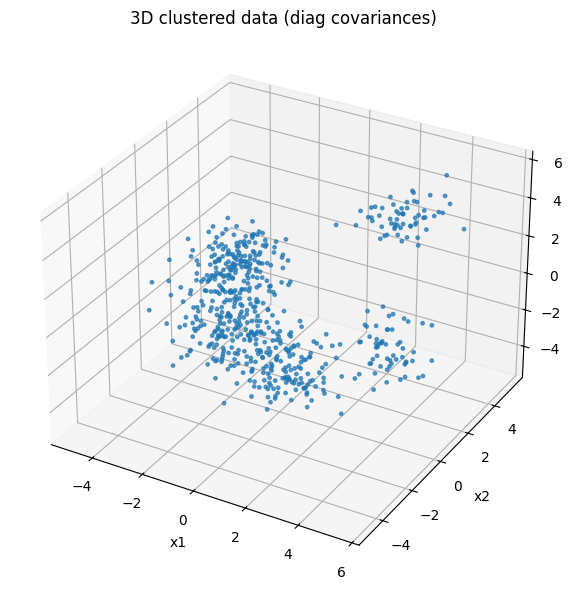

In [183]:
def GMM3d(K: int, seed: int, n: int, cov_diag_min: float, cov_diag_max: float, mean_min: float, mean_max: float):
    np.random.seed(seed)
    d = 3 #initial 3-d dimension
    datapoints = n
    mus = []
    covs = []
    x_clusters = []
    n_cluster_size = n // K
    
    for i in range(K): 
         
        mus.append(np.random.uniform(mean_min, mean_max, size = d)) 
        
        covs.append(np.diag(np.random.uniform(cov_diag_min,cov_diag_max,size =d)))
        
        x_clusters.append(np.random.multivariate_normal(mus[i], covs[i], size = n_cluster_size, check_valid='raise'))
        
    X = np.vstack(x_clusters)

    return X
    
X = GMM3d(K=10, seed=7, n=600, cov_diag_min=0.2, cov_diag_max=1.0, mean_min=-4, mean_max=4)

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], s=6, alpha=0.7)
ax.set_xlabel('x1'); ax.set_ylabel('x2'); ax.set_zlabel('x3')
ax.set_title('3D clustered data (diag covariances)')
plt.tight_layout(); plt.show()
        

In [182]:
# Initialize a semi-randomly guessed parameters for C Gaussian Distributions

def initialized_params(X: np.array, C: int):
    n_datapoints, n_features = X.shape
    pi = np.ones(C) / C # uniform probability of a datapoint coming from a distribution
    mu =  X[np.random.choice(n_datapoints, C, False)] #choose C random points to initialize a mean for each C
    sigma = [np.diag(X.var(axis = 0))] * C 
    return pi, mu , sigma

def multivariate_norm_pdf(X: np.array, mu: np.array, sigma: np.array): # this computes the norm_pdf of a datapoint across entire dataset for that specific gaussian mean and covariance
    _, n_features = X.shape
    coeff = 1 / np.sqrt((2 * np.pi) ** n_features * np.linalg.det(sigma))
    diff = X - mu
    inv_sigma = np.linalg.inv(sigma)
    exponent = -0.5 * np.sum(diff @ inv_sigma * diff, axis=1)
    return coeff * np.exp(exponent)
    

In [181]:
class EM:
    def __init__(self, X, C, max_iterations = 100):
        self.X = X
        self.C = C
        self.N = X.shape[0]
        self.pi, self.mu, self.sigma = initialized_params(X, C)
        self.prob_matrix = np.zeros((self.N, self.C))
    
    def expectation(self):
        for c in range(self.C):
            self.prob_matrix[:, c] = self.pi[c] * multivariate_norm_pdf(self.X, self.mu[c], self.sigma[c]) # get matrix of probability of a datapoint belonging to some class c (N x C)
        denominator = np.sum(self.prob_matrix, axis = 1).reshape(-1,1) # denominator vector
        denominator = np.clip(denominator, 1e-12, None)

        self.prob_matrix = self.prob_matrix / denominator
    
    def maximization(self):
        #updating the parameters for distributions
        #sum of probabilities of each cluster
        sum_prob = np.sum(self.prob_matrix, axis = 0) # this gets the total "responsibility" for each cluster (1xC)
        self.pi = sum_prob / self.N # new weighted pi for each componenet from expectation (1xC)

        for c in range(self.C):
    
            self.mu[c] = (1/sum_prob[c]) * np.sum(self.X * self.prob_matrix[:,c].reshape(-1,1), axis = 0) # weighted mean of the data per componenet from expectation
            
            diff = self.X - self.mu[c] 
            self.sigma[c] = (1/sum_prob[c]) * ((diff * self.prob_matrix[:,c].reshape(-1,1)).T @ diff) # updated covar parameters best fits from expectation

        

    def fit(self, num_iters):
        for i in range(num_iters):
            self.expectation()
            self.maximization()
            plot_em_step_3d(self.X, self.mu, self.sigma, gamma=self.prob_matrix, title=f"Iter {i}")

        
        

In [179]:
em_model = EM(X, C = 4)

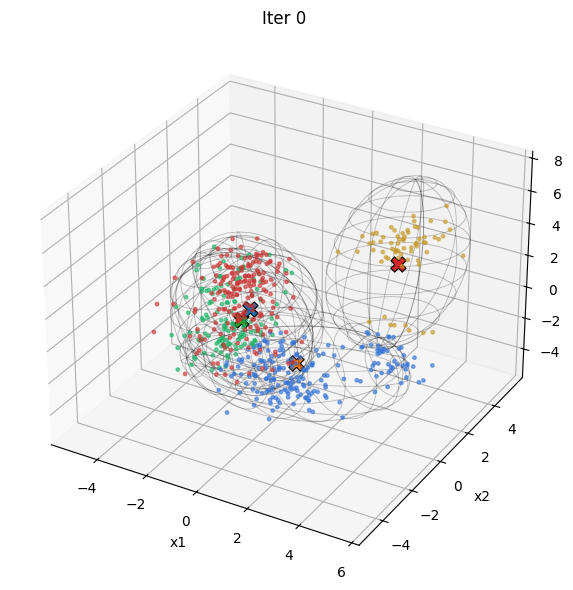

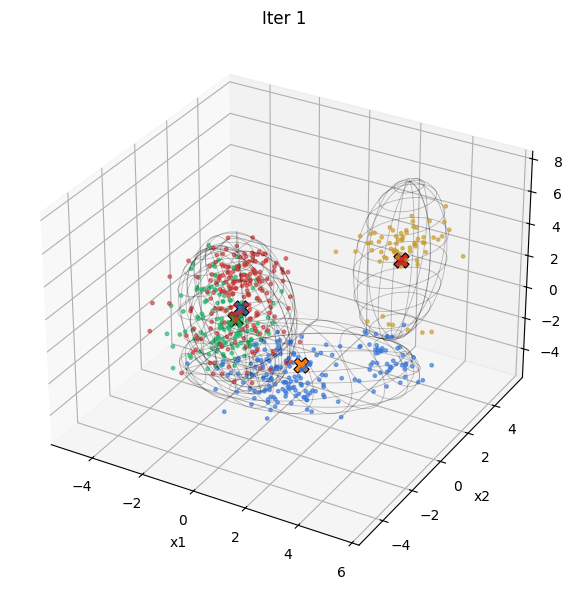

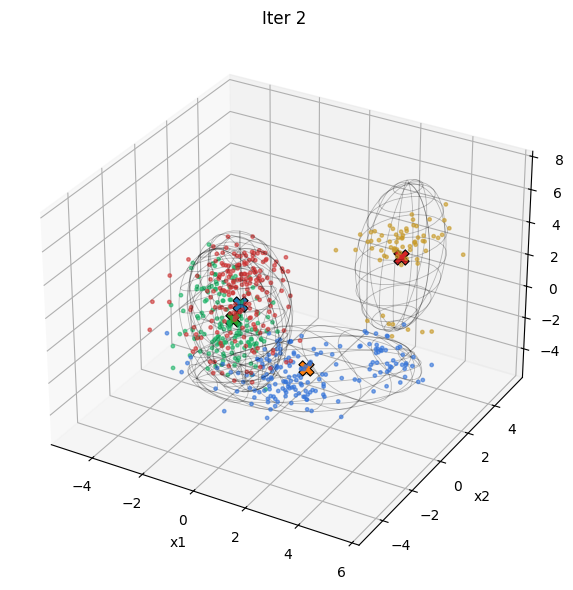

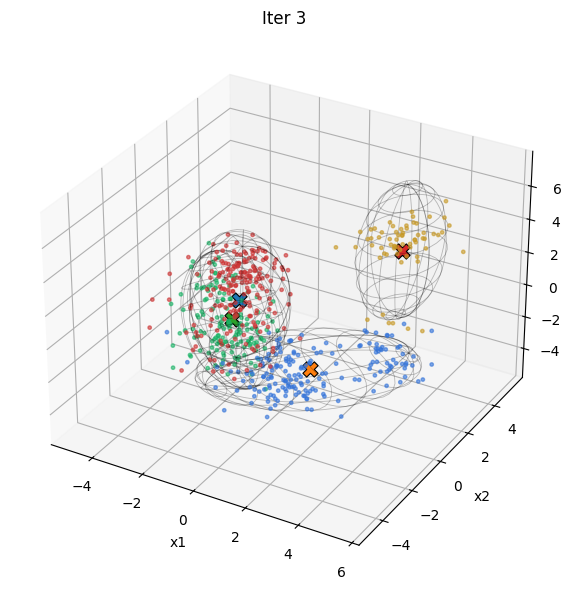

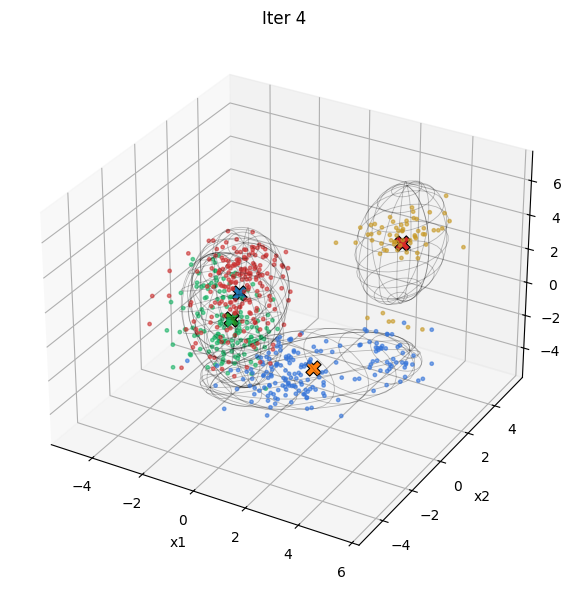

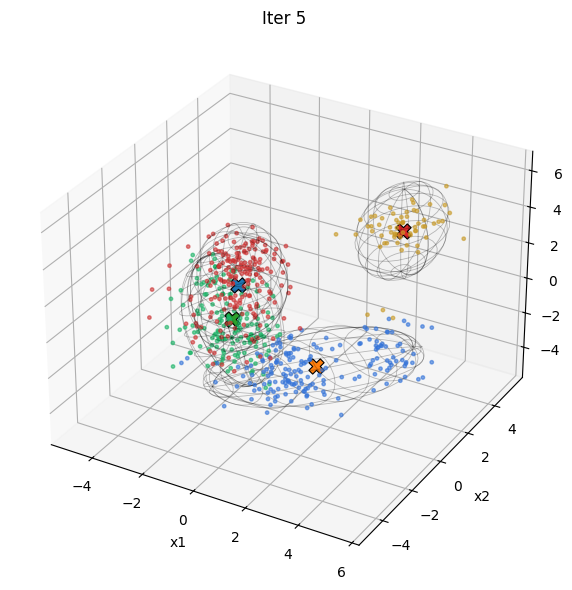

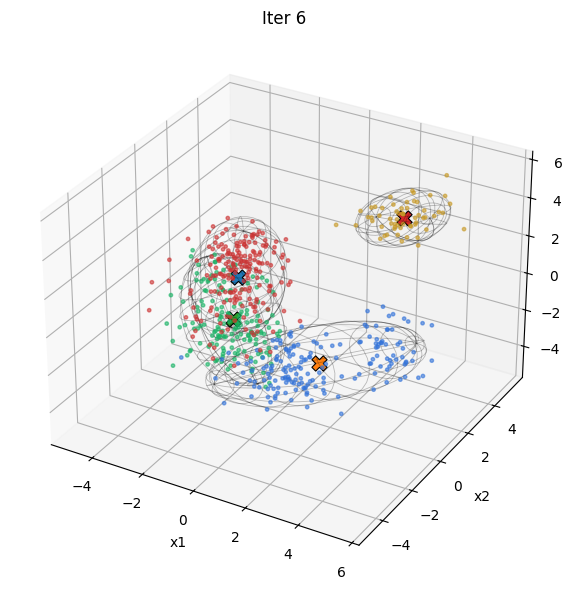

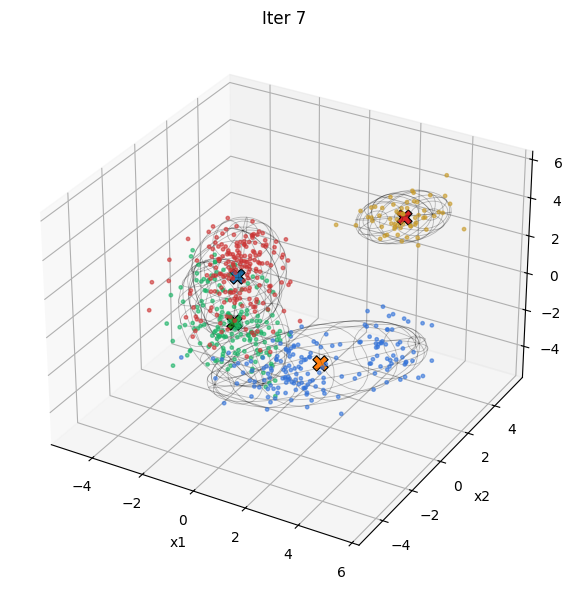

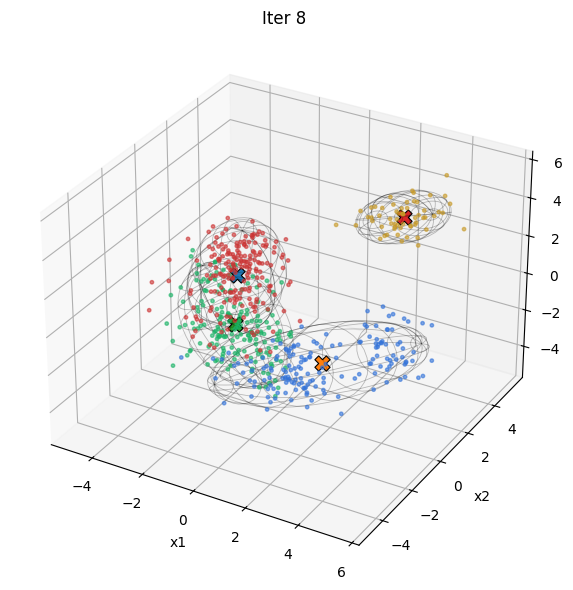

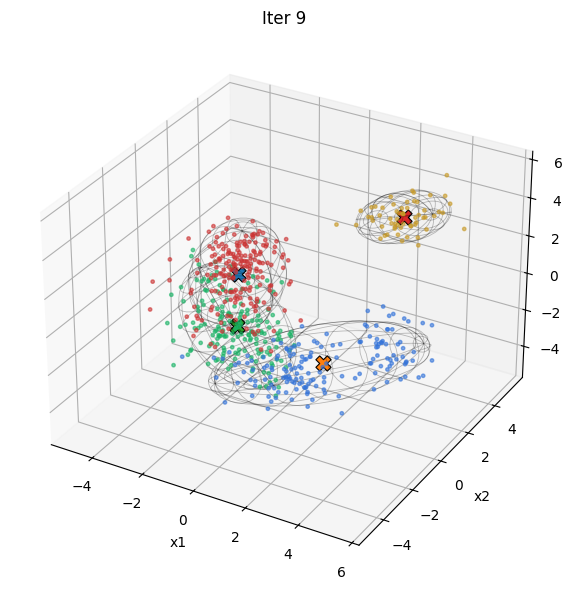

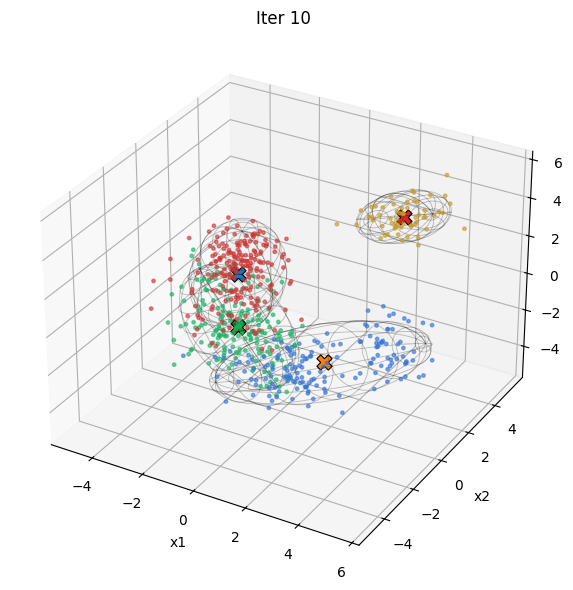

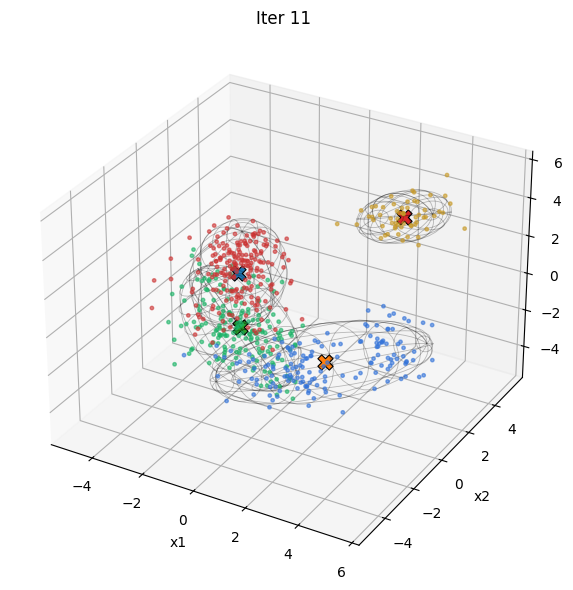

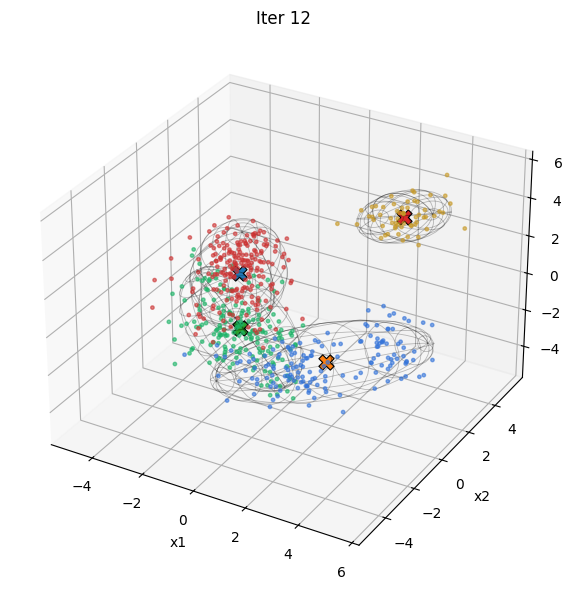

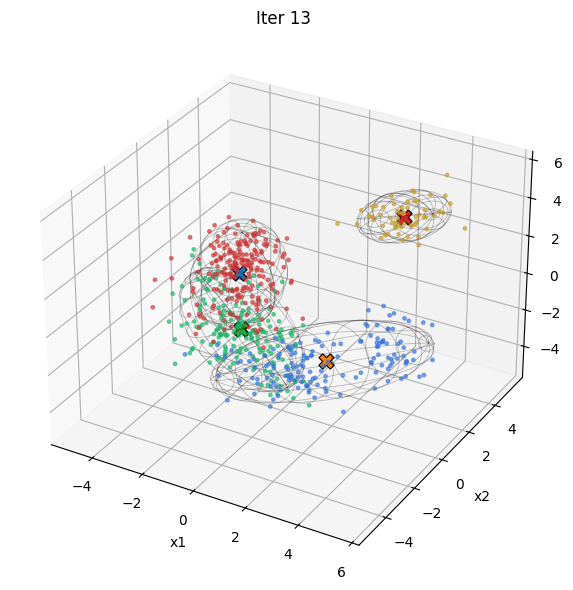

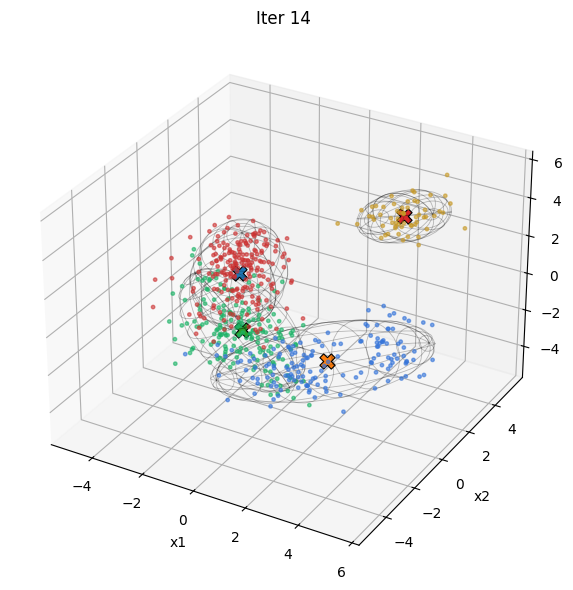

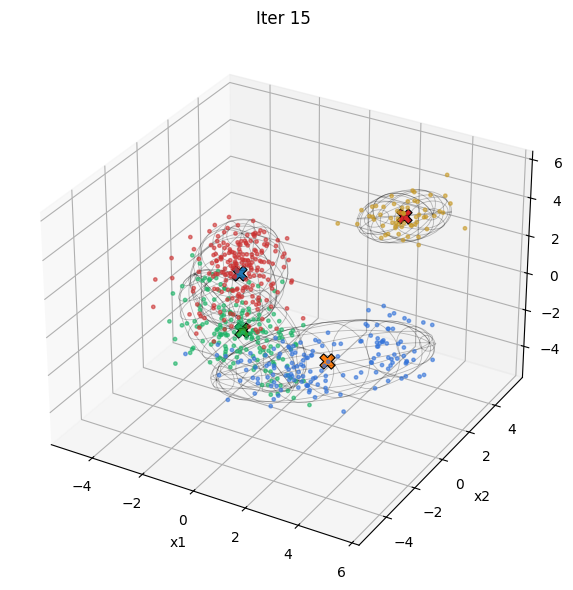

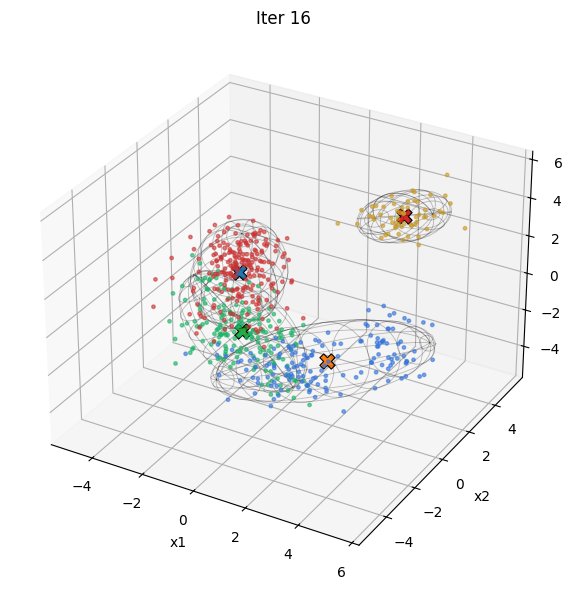

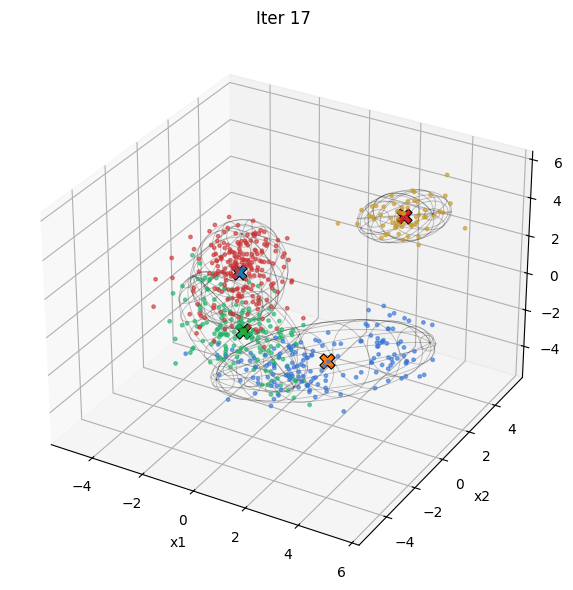

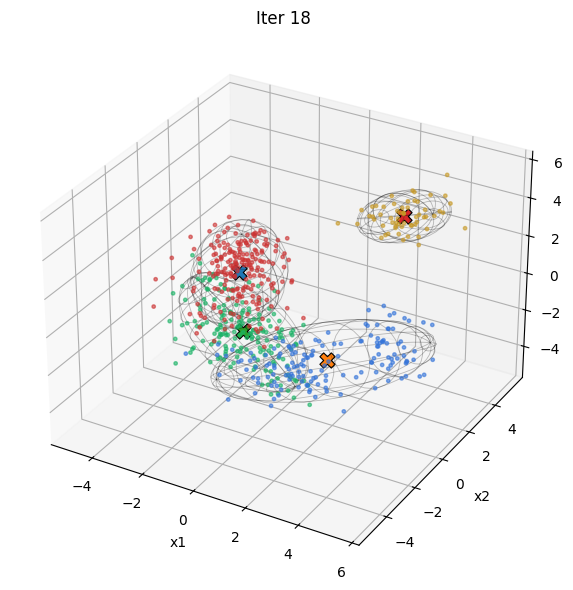

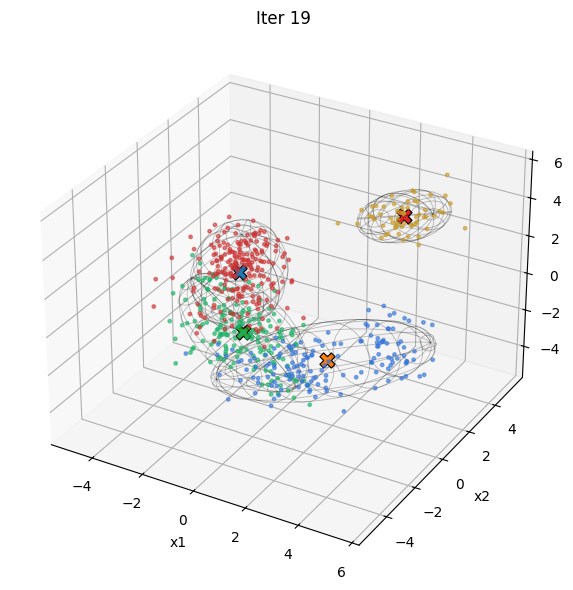

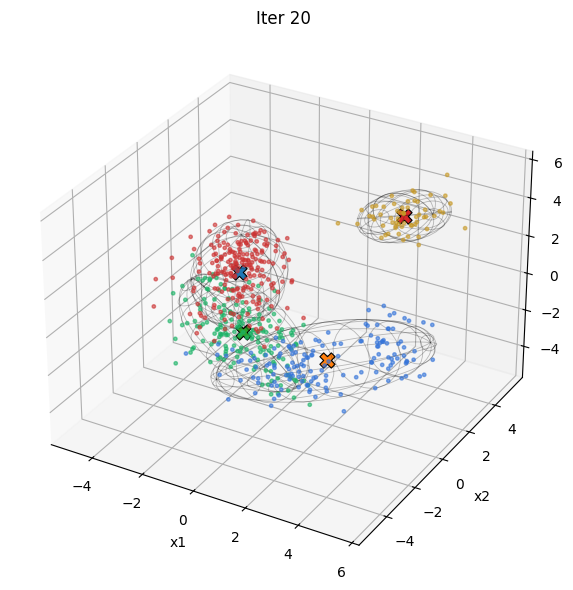

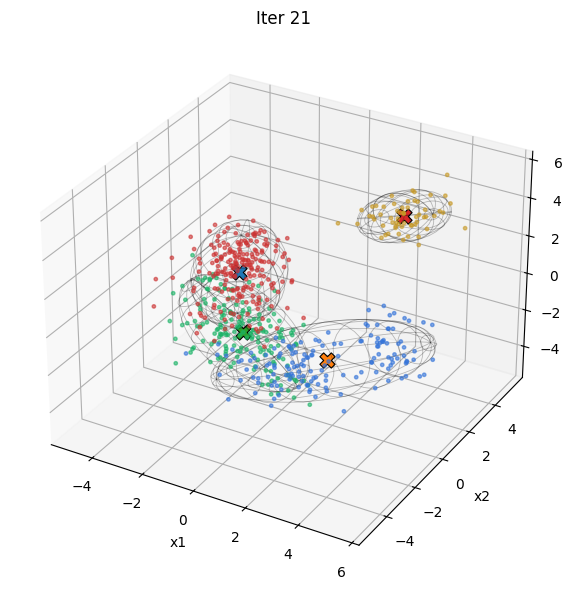

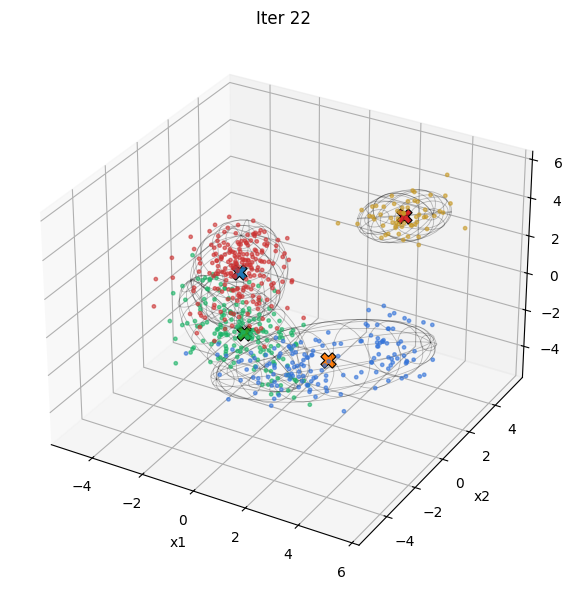

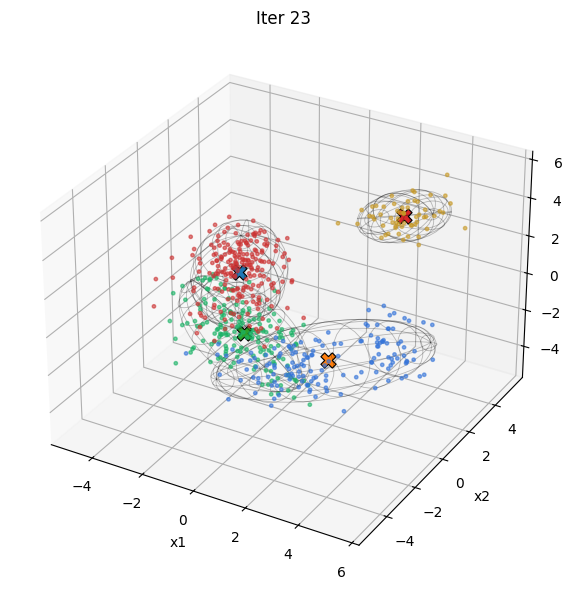

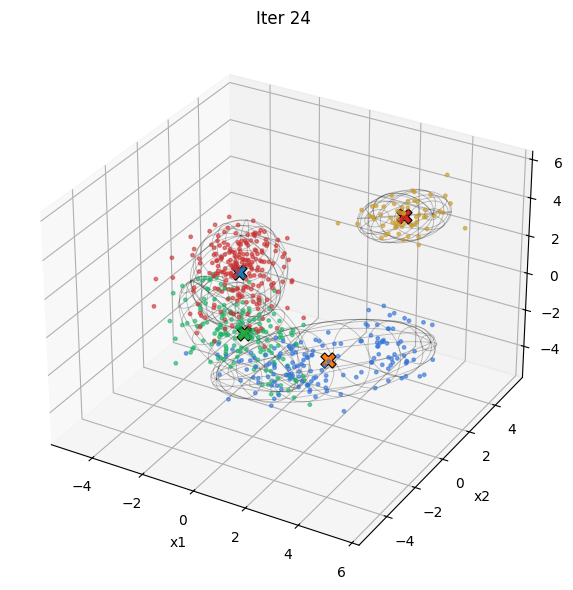

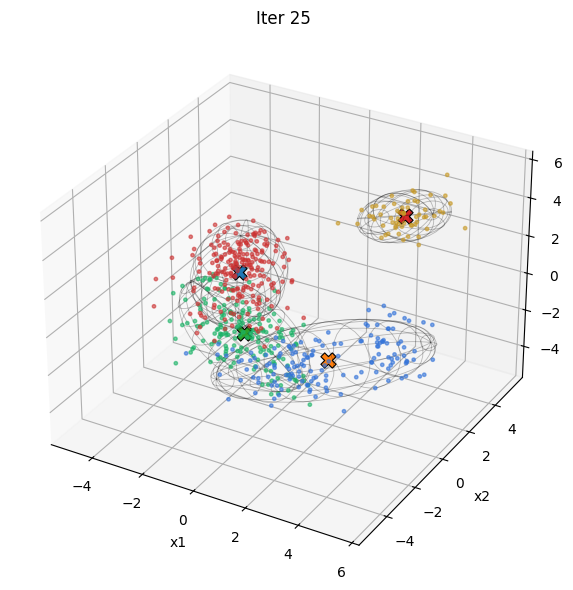

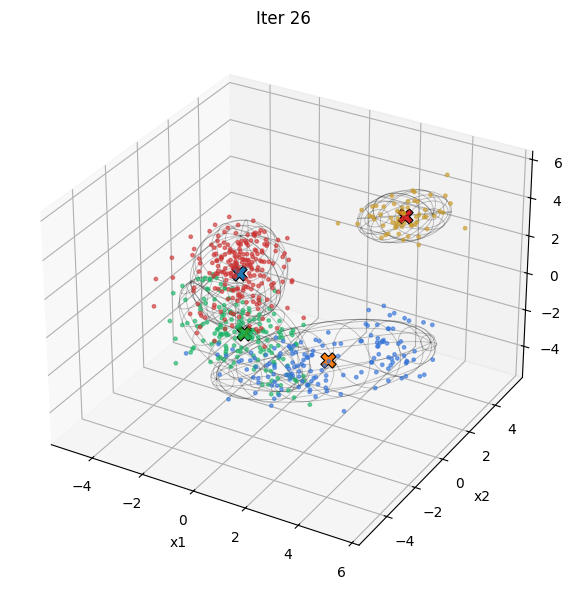

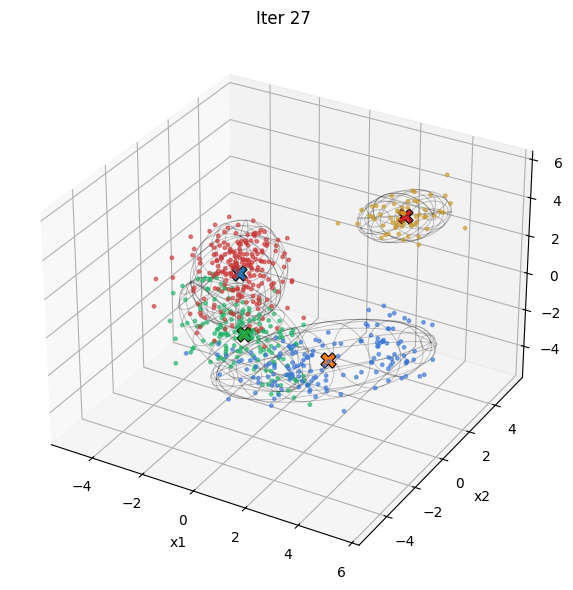

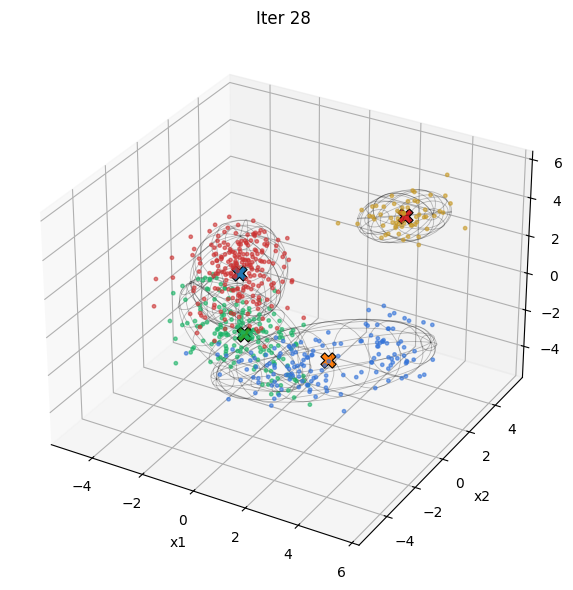

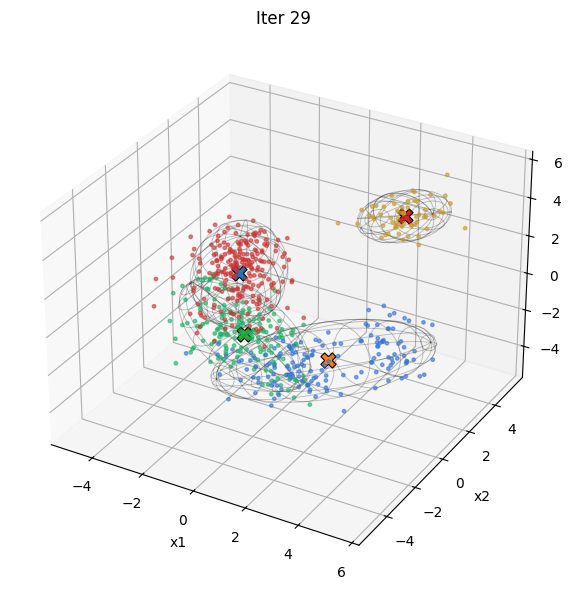

In [180]:
em_model.fit(num_iters = 30)

In [175]:
def draw_cov_ellipsoid(ax, mu, Sigma, n_std=2.0, n_pts=30, **plot_kw):
    # Eigen-decompose covariance
    vals, vecs = np.linalg.eigh(Sigma)
    # Radii along principal axes (n_std = 2 ~ 95% mass for Gaussian)
    radii = n_std * np.sqrt(np.maximum(vals, 0))
    # Parametric sphere
    u = np.linspace(0, 2*np.pi, n_pts)
    v = np.linspace(0, np.pi, n_pts)
    xs = np.outer(np.cos(u), np.sin(v))
    ys = np.outer(np.sin(u), np.sin(v))
    zs = np.outer(np.ones_like(u), np.cos(v))
    # Stack and rotate + translate
    P = np.stack([xs, ys, zs], axis=-1)            # (n_pts, n_pts, 3)
    ell = (P * radii) @ vecs.T + mu                # broadcast scale+rotate+shift
    ax.plot_wireframe(ell[...,0], ell[...,1], ell[...,2], rstride=3, cstride=3, **plot_kw)

def plot_em_step_3d(X, mus, sigmas, gamma=None, title="EM step"):
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection='3d')

    # Color by hard assignment or soft hue
    if gamma is not None:
        labels = np.argmax(gamma, axis=1)  # hard
    else:
        labels = np.zeros(X.shape[0], dtype=int)

    # Use a small palette that works in 3D
    palette = np.array([
        [0.80,0.20,0.20], [0.20,0.45,0.85], [0.10,0.70,0.40],
        [0.78,0.60,0.15], [0.60,0.30,0.70], [0.20,0.70,0.70],
        [0.90,0.35,0.10], [0.35,0.35,0.35], [0.10,0.10,0.70], [0.70,0.10,0.10]
    ])
    colors = palette[labels % len(palette)]

    ax.scatter(X[:,0], X[:,1], X[:,2], s=6, alpha=0.6, c=colors, depthshade=False)

    # Means and ellipsoids
    for k, (m, S) in enumerate(zip(mus, sigmas)):
        ax.scatter(m[0], m[1], m[2], s=120, marker='X', edgecolor='k', linewidths=0.8, zorder=5)
        draw_cov_ellipsoid(ax, m, S, n_std=2.0, color='k', linewidth=0.6, alpha=0.25)

    ax.set_xlabel('x1'); ax.set_ylabel('x2'); ax.set_zlabel('x3')
    ax.set_title(title)
    plt.tight_layout()
    plt.show()